# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we removed left-handed subjects and normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data with two different smoothing kernel (``fwhm= [4, 8]``) and two different normalizations (ANTs and SPM).

This example will also directly include thresholding of the output, as well as some visualization.

**Let's start!**

# Group Analysis with SPM

Let's first run the group analysis with the SPM normalized data.

## Imports (SPM12)

First, we need to import all the modules we later want to use.

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [2]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 'con_0006', 'con_0007']

mask = "/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [4]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'norm_spm', 'sub-*_fwhm{fwhm_id}',
                         'w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [5]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

211018-12:45:20,987 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/spm_l2analysis/graph.png (graph2use=colored, simple_form=True).


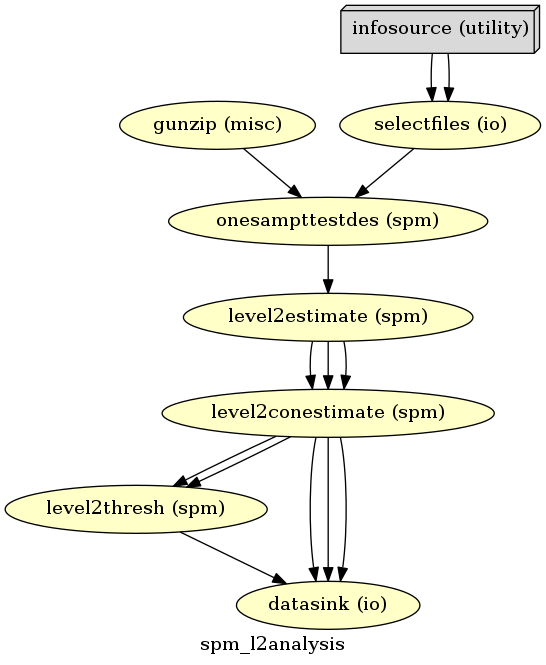

In [6]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [7]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

211018-12:45:23,614 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
211018-12:45:23,685 nipype.workflow INFO:
	 Running in parallel.
211018-12:45:23,690 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 15 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:45:23,799 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles".
211018-12:45:23,799 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_4/selectfiles".
211018-12:45:23,798 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles".
211018-12:45:23,798 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id

211018-12:45:31,787 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.onesampttestdes" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/onesampttestdes".
211018-12:45:31,787 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.onesampttestdes" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/onesampttestdes".
211018-12:45:31,802 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
211018-12:45:31,802 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
211018-12:45:31,802 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
211018-12:45:31,814 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
211018-12:45:33,704 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 4.43

211018-12:47:32,848 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211018-12:47:32,852 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211018-12:47:34,719 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 4.43/5.23, Free processors: 0/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
211018-12:47:38,562 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:47:38,583 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:47:38,646 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:47:38,658 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12

211018-12:47:48,998 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211018-12:47:49,18 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211018-12:47:50,742 nipype.workflow INFO:
	 [Job 35] Completed (spm_l2analysis.onesampttestdes).
211018-12:47:50,745 nipype.workflow INFO:
	 [Job 40] Completed (spm_l2analysis.onesampttestdes).
211018-12:47:50,748 nipype.workflow INFO:
	 [Job 45] Completed (spm_l2analysis.onesampttestdes).
211018-12:47:50,751 nipype.workflow INFO:
	 [Job 50] Completed (spm_l2analysis.onesampttestdes).
211018-12:47:50,756 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:47:50,851 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2estimate".
211018-12:47:50,854 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/ou

211018-12:48:40,616 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:48:41,660 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:48:41,920 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:48:41,999 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211018-12:48:42,200 nipype.workflow INFO:
	 [Job 53] Completed (spm_l2analysis.level2thresh).
211018-12:48:42,204 nipype.workflow INFO:
	 [Job 38] Completed (spm_l2analysis.level2thresh).
211018-12:48:42,206 nipype.workflow INFO:
	 [Job 43] Completed (spm_l2analysis.level2thresh).
211018-12:48:42,209 nipype.workflow INFO:
	 [Job 48] Completed (spm_l2analysis.level2thresh).
211018-12:48:42,214 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:48:42,282 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/output/workingdir/spm_l2

211018-12:48:52,300 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2estimate".
211018-12:48:52,300 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2estimate".
211018-12:48:52,301 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_8/level2estimate".
211018-12:48:52,301 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_4/level2estimate".
211018-12:48:52,312 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
211018-12:48:52,313 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
211018-12:48:52,313 nipype.workf

211018-12:49:42,438 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:49:42,439 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:49:42,438 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:49:42,438 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:49:42,443 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0003_fwhm_id_8/SPM.mat -> /output/datasink/2ndLevel/spm_con_0003_fwhm8/SPM.mat
211018-12:49:42,443 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_4/SPM.mat -> /output/datasink/2ndLevel/spm_con_0002_fwhm4/SPM.mat
211018-12:49:42,442 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0003_fwhm_id_4/SPM.mat -> /output/datasink/2ndLevel/spm_con_0003_fwhm4/SPM.mat
211018-12:49:42,448 nipype.interface INFO:
	 sub: /output/datasink/2

211018-12:50:20,321 nipype.workflow INFO:
	 [Job 82] Completed (spm_l2analysis.level2conestimate).
211018-12:50:20,326 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:50:20,397 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/level2thresh".
211018-12:50:20,397 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2thresh".
211018-12:50:20,422 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211018-12:50:20,425 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211018-12:50:22,319 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 4.83/5.23, Free processors: 2/4.
                     Currently 

# Group Analysis with ANTs

Now to run the same group analysis, but on the ANTs normalized images, we just need to change a few parameters:

In [8]:
# Change the SelectFiles template and recreate the node
templates = {'cons': opj(output_dir, 'norm_ants', 'sub-*_fwhm{fwhm_id}',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

Now, we just have to recreate the workflow.

In [9]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

And we can run it!

In [10]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

211018-12:51:01,558 nipype.workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
211018-12:51:01,660 nipype.workflow INFO:
	 Running in parallel.
211018-12:51:01,668 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 15 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:51:01,792 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/output/workingdir/ants_l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles".
211018-12:51:01,809 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211018-12:51:01,815 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/output/workingdir/ants_l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles".
211018-12:51:01,816 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/output/workingdir/ants_l2analysis/_contrast_id_con_0006_fwhm_id_4/selectfiles".
211018-12:51:01,815 nipy

211018-12:51:09,796 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.onesampttestdes" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/onesampttestdes".
211018-12:51:09,800 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211018-12:51:09,804 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211018-12:51:09,809 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
211018-12:51:09,812 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.onesampttestdes" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/onesampttestdes".
211018-12:51:09,815 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211018-12:51:09,825 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
211018-12:51:09,834 nipype.workflow INFO:
	 

211018-12:52:05,763 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")
211018-12:52:07,535 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 4.43/5.23, Free processors: 0/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211018-12:52:19,561 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211018-12:52:19,728 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211018-12:52:19,729 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211018-12:52:19,745 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211018-12:52:21,559 nipype.workflow INFO:
	 [Job 17] Completed (spm_l2ana

211018-12:52:32,465 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0006_fwhm_id_8/con_0001.nii -> /output/datasink/2ndLevel/ants_con_0006_fwhm8/con_0001.nii
211018-12:52:32,468 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0006_fwhm_id_8/spmT_0001_thr.nii -> /output/datasink/2ndLevel/ants_con_0006_fwhm8/spmT_0001_thr.nii
211018-12:52:32,472 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211018-12:52:32,477 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.datasink".
211018-12:52:32,478 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_4/datasink".
211018-12:52:32,479 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211018-12:52:32,487 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:52:32,489 nipype.interface INFO:
	 sub: /output/

211018-12:53:28,549 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211018-12:53:30,123 nipype.workflow INFO:
	 [Job 41] Completed (spm_l2analysis.level2estimate).
211018-12:53:30,130 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 4.63/5.23, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211018-12:53:30,145 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211018-12:53:30,347 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211018-12:53:30,356 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/level2conestimate".
211018-12:53:30,368 nipype.workflow INFO:
	 [Node] Outdated cache found 

211018-12:53:54,306 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/datasink".
211018-12:53:54,309 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211018-12:53:54,324 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:53:54,330 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_8/SPM.mat -> /output/datasink/2ndLevel/ants_con_0005_fwhm8/SPM.mat
211018-12:53:54,333 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_8/spmT_0001.nii -> /output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001.nii
211018-12:53:54,335 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_8/con_0001.nii -> /output/datasink/2ndLevel/ants_con_0005_fwhm8/con_0001.nii
211018-12:53:54,338 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contra

211018-12:54:04,519 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211018-12:54:04,551 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211018-12:54:04,571 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211018-12:54:06,188 nipype.workflow INFO:
	 [Job 55] Completed (spm_l2analysis.onesampttestdes).
211018-12:54:06,191 nipype.workflow INFO:
	 [Job 60] Completed (spm_l2analysis.onesampttestdes).
211018-12:54:06,193 nipype.workflow INFO:
	 [Job 65] Completed (spm_l2analysis.onesampttestdes).
211018-12:54:06,195 nipype.workflow INFO:
	 [Job 70] Completed (spm_l2analysis.onesampttestdes).
211018-12:54:06,199 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:54:06,304 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211018-12:54:06,310 nipype.workflow INFO:
	 [Node] Outdated cache found for "sp

211018-12:54:56,414 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211018-12:54:56,414 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211018-12:54:56,422 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2thresh".
211018-12:54:56,428 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211018-12:54:56,434 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211018-12:54:56,443 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_8/level2thresh".
211018-12:54:56,448 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211018-12:54:56,448 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Thresho

211018-12:55:06,412 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211018-12:55:06,419 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211018-12:55:06,420 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:55:06,426 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.onesampttestdes" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/onesampttestdes".
211018-12:55:06,424 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_4/SPM.mat -> /output/datasink/2ndLevel/ants_con_0002_fwhm4/SPM.mat
211018-12:55:06,429 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211018-12:55:06,434 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211018-12:55:06,435 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.

211018-12:56:04,373 nipype.workflow INFO:
	 [Job 78] Completed (spm_l2analysis.level2thresh).
211018-12:56:04,376 nipype.workflow INFO:
	 [Job 83] Completed (spm_l2analysis.level2thresh).
211018-12:56:04,381 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:56:04,476 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211018-12:56:04,482 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/datasink".
211018-12:56:04,485 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211018-12:56:04,587 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:56:04,590 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0001_fwhm_id_8/SPM.mat -> /output/datasink/2ndLevel/ants_con_0001_fwhm8/SPM.mat
211018-12:56:04,59

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

In [11]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

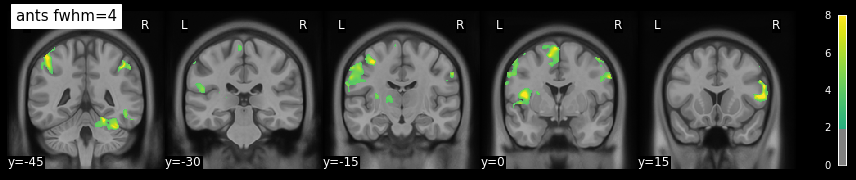

In [12]:
plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

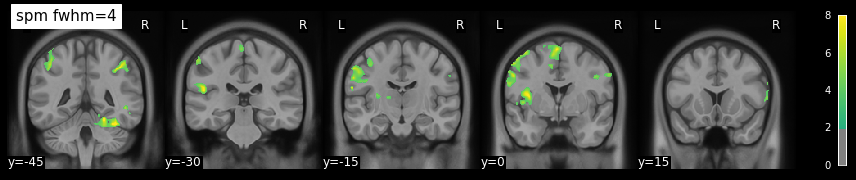

In [13]:
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

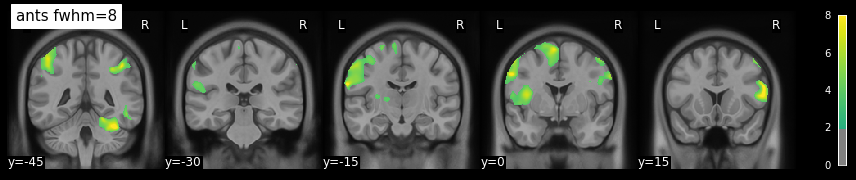

In [14]:
plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

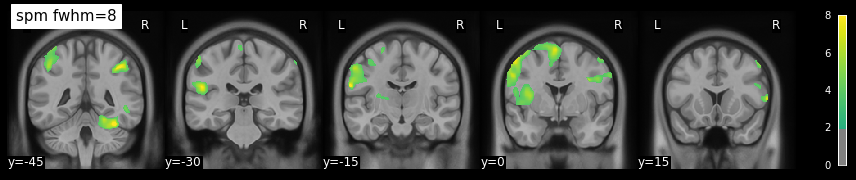

In [15]:
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8',
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

Now, let's see other contrast -- **Finger > others**. Since we removed left-handed subjects, the activation is seen on the left part of the brain.

In [16]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

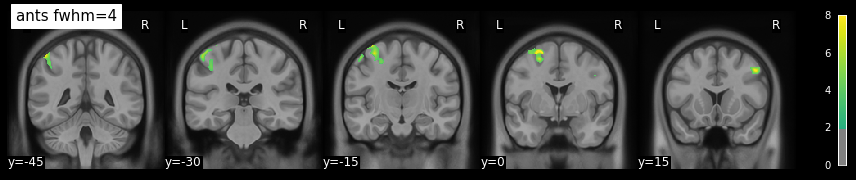

In [17]:
plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

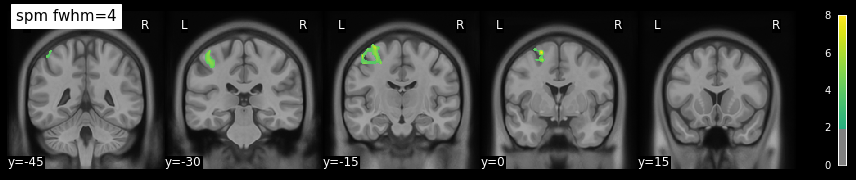

In [18]:
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

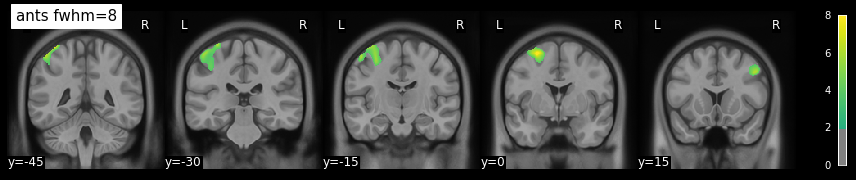

In [19]:
plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

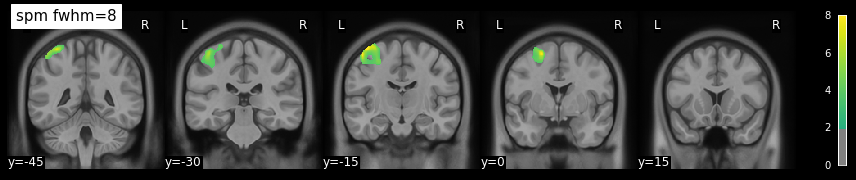

In [20]:
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

Now, let's see the results using the glass brain plotting method.

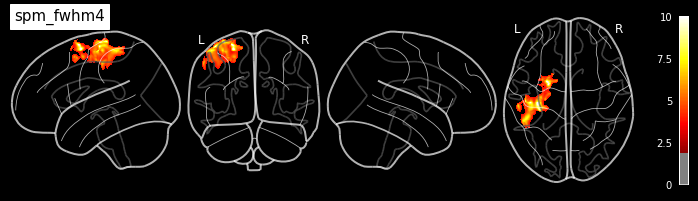

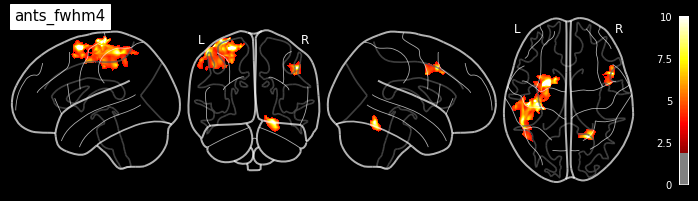

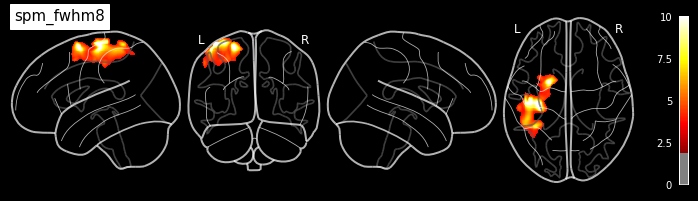

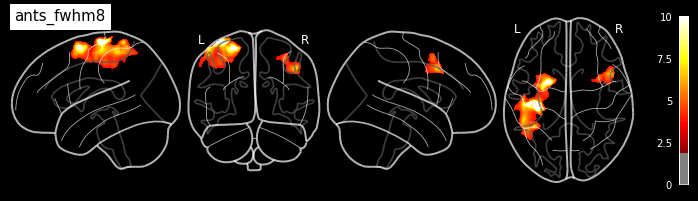

In [21]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm4');
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4');
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm8');
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm8');